# Projeto de Dados - Olist E-commerce

Analisar dados de e-commerce da empresa Olist a fim de extrair insights de negócio, responder perguntas específicas sobre vendas, entregas e comportamento dos clientes, além de criar visualizações que auxiliem na tomada de decisão.

In [ ]:
# Importando todas as bibliotecas necessárias
import pandas as pd
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine

## 📥 Importação dos Dados

- Leitura dos CSVs para DataFrames
- Obs: A base product_category_name_translation não será utilizada, pois a base products já possui a coluna 'product_category_name'.

In [113]:
df_csv_customers = pd.read_csv('data/olist_customers_dataset.csv')
df_csv_geolocation = pd.read_csv('data/olist_geolocation_dataset.csv')
df_csv_order_items = pd.read_csv('data/olist_order_items_dataset.csv')
df_csv_payments = pd.read_csv('data/olist_order_payments_dataset.csv')
df_csv_reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')
df_csv_orders = pd.read_csv('data/olist_orders_dataset.csv')
df_csv_products = pd.read_csv('data/olist_products_dataset.csv')
df_csv_sellers = pd.read_csv('data/olist_sellers_dataset.csv')

## 🧹 Limpeza e Transformação dos Dados

A limpeza nos dataframes a baixo é feita para evitar duplicidade de dados, selecionar apenas as colunas necessárias 
e evitar erros de leitura. Algumas colunas são renomeadas para facilitar a leitura e o entendimento do código.

- Tratamento de nulos, tipos, duplicatas
- Normalização e seleção de colunas a serem utilizadas

In [ ]:
# Foi identificado que a base 'orders' possui valores nulos em colunas relevantes de data 
# (order_delivered_carrier_date, order_delivered_customer_date, order_approved_at).
# Para evitar perda de dados, foi criada a coluna 'customer_confirmed_delivery', que assume False
# quando as datas de entrega e aprovação estão ausentes, indicando que o pedido não foi concluído.
def transf_orders(df):
    cols_to_convert = [
        'order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date'
    ]
    df[cols_to_convert] = df[cols_to_convert].apply(pd.to_datetime, errors='coerce')

    df['customer_confirmed_delivery'] = (
        df['order_delivered_carrier_date'].isna() &
        df['order_delivered_customer_date'].isna() &
        df['order_approved_at'].isna()
    )
    return df


# Colunas de preço e frete são renomeadas.
# Criação da coluna 'qtd_order_item' com o total de itens, visto que um pedido pode ter mais de uma linha referente ao mesmo produto.
def transf_orders_items(df):
    df['shipping_limit_date'] = pd.to_datetime(df['shipping_limit_date'])
    df = df.groupby(['order_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']).agg(
        qtd_order_item=('order_id', 'count')
    ).reset_index()
    return df.rename(columns={'price': 'product_price', 'freight_value': 'product_shipping_cost'})


# A base de pagamentos pode conter múltiplos registros por pedido, então somamos o valor total pago por pedido.
# Visto que um mesmo pedido pode ter mais de um pagamento, e na análise não é necessário saber o tipo de pagamento ou outras informações.
def transf_payments(df):
    return df.groupby('order_id').agg(total_order_payments =('payment_value', 'sum')).reset_index()


# Caso existam múltiplas avaliações para o mesmo pedido, será considerada apenas a maior nota.
# Além disso, somente as colunas order_id e review_score são mantidas. 
def transf_reviews(df):
    return df.groupby('order_id')['review_score'].max().reset_index(name='order_score_review')


# Mantém apenas ID e categoria dos produtos. Caso a categoria seja nula, será substituída por 'sem_categoria'.
def transf_product(df):
    df['product_category_name'] = df['product_category_name'].fillna('sem_categoria')
    return df[['product_id', 'product_category_name']]

## ✅ Validação de Consistência dos Dados

- Função para identificar nulos, strings vazias e valores negativos.
- Parâmetro opcional para ignorar colunas numéricas específicas ao verificar valores negativos.

In [178]:
def check_inconsistencies(df, nome, ignore_negative_cols=None):
    inconsistencias = []

    # Duplicatas
    duplicadas = df.duplicated().sum()
    if duplicadas > 0:
        inconsistencias.append(f"- Duplicadas: {duplicadas}")

    # Nulos
    nulos = df.isnull().sum()
    nulos = nulos[nulos > 0]
    if not nulos.empty:
        inconsistencias.append("- Valores nulos:\n" + str(nulos))

    # Strings vazias
    vazias = df.select_dtypes(include='object').apply(lambda col: (col == '').sum())
    vazias = vazias[vazias > 0]
    if not vazias.empty:
        inconsistencias.append("- Strings vazias (''):\n" + str(vazias))

    # Valores negativos
    numeric_cols = df.select_dtypes(include='number')
    if ignore_negative_cols:
        numeric_cols = numeric_cols.drop(columns=ignore_negative_cols, errors='ignore')
    negativos = (numeric_cols < 0).sum()
    negativos = negativos[negativos > 0]
    if not negativos.empty:
        inconsistencias.append("- Valores negativos:\n" + str(negativos))

    # Exibe somente se houver alguma inconsistência
    if inconsistencias:
        print(f"\n {nome.upper()}")
        for item in inconsistencias:
            print(item)


In [179]:
# Lembre-se que o df_orders terá dados nulos, pois a coluna customer_confirmed_delivery foi criada para resolver isso.

df_orders = transf_orders(df_csv_orders)
check_inconsistencies(df_orders, 'df_orders')

df_customers = df_csv_customers.drop_duplicates()
check_inconsistencies(df_customers, 'df_customers')

df_geolacation = df_csv_geolocation.drop_duplicates()
check_inconsistencies(df_geolacation, 'df_geolocation', ignore_negative_cols=['geolocation_lat','geolocation_lng'])

df_sellers = df_csv_sellers.drop_duplicates()
check_inconsistencies(df_sellers, 'df_sellers')

df_orders_items = transf_orders_items(df_csv_order_items)
df_orders_items_valid = check_inconsistencies(df_orders_items, 'df_orders_items')

df_payments = transf_payments(df_csv_payments)
df_payments_valid = check_inconsistencies(df_payments, 'df_payments')

df_reviews = transf_reviews(df_csv_reviews)
df_reviews_valid = check_inconsistencies(df_reviews, 'df_reviews')

df_products = transf_product(df_csv_products)
df_products_valid = check_inconsistencies(df_products, 'df_products')


 DF_ORDERS
- Valores nulos:
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
delivery_time                    2965
dtype: int64


## Análise Exploratória de Dados (EDA) e Visualizações

### Perguntas Respondidas:
- a) Qual o volume de pedidos por mês? Existe sazonalidade nas vendas?
- b) Qual a distribuição do tempo de entrega dos pedidos?
- c) Qual a relação entre o valor do frete e a distância de entrega?
- d) Quais são as categorias de produtos mais vendidas em termos de faturamento?
- e) Quais estados brasileiros possuem o maior valor médio de pedido?


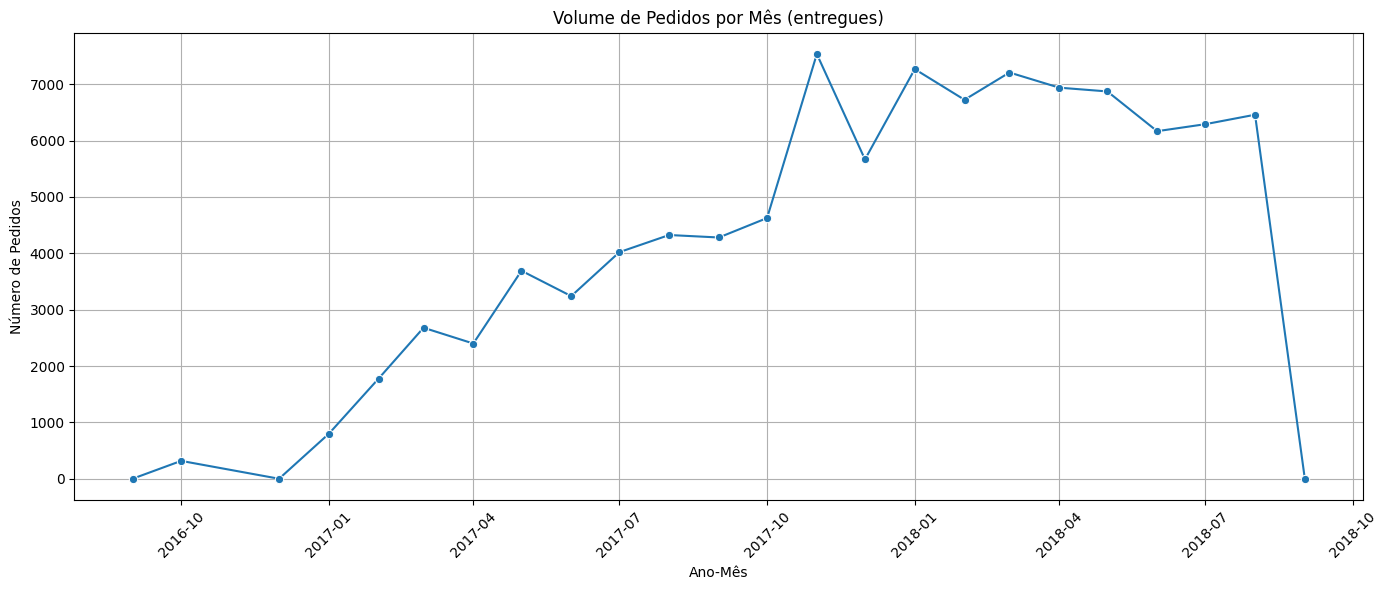

In [ ]:
# Qual o volume de pedidos por mês? Existe sazonalidade nas vendas?

df_orders['year_month'] = df_orders['order_purchase_timestamp'].dt.to_period('M').astype(str)

df_orders_entregues = df_orders[df_orders['customer_confirmed_delivery'] == False]
monthly_orders = df_orders_entregues.groupby('year_month').size().reset_index(name='order_count')

monthly_orders['year_month'] = pd.to_datetime(monthly_orders['year_month'])

plt.figure(figsize=(14,6))
sns.lineplot(data=monthly_orders, x="year_month", y="order_count", marker="o") 
plt.xticks(rotation=45)                                                                
plt.title("Volume de Pedidos por Mês (entregues)")                                               
plt.xlabel("Ano-Mês")
plt.ylabel("Número de Pedidos")
plt.grid(True)
plt.tight_layout()
plt.show()

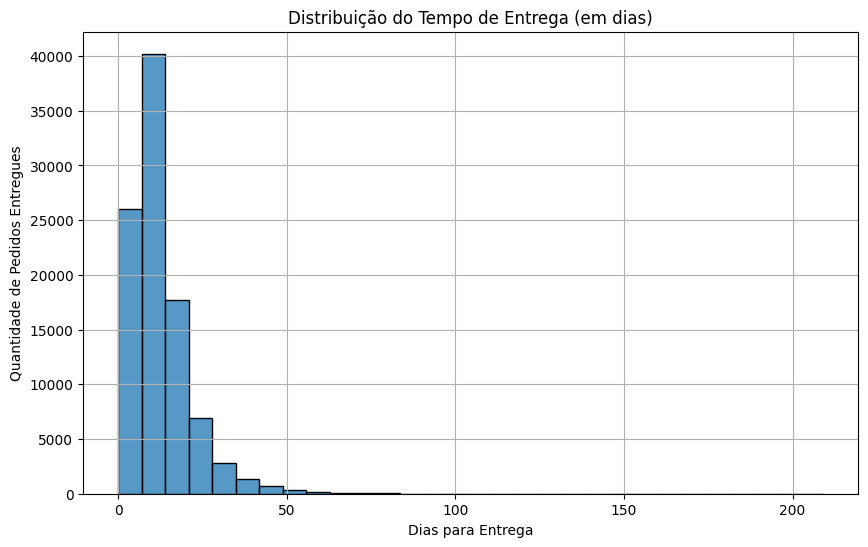

In [ ]:
# Qual a distribuição do tempo de entrega dos pedidos?

df_entregues = df_orders[df_orders['customer_confirmed_delivery'] == False].copy()

df_entregues['delivery_time'] = (
    df_entregues['order_delivered_customer_date'] - df_entregues['order_purchase_timestamp']
).dt.days


delivery_times = df_entregues['delivery_time'].dropna()
delivery_times = delivery_times[delivery_times >= 0]

plt.figure(figsize=(10,6))
sns.histplot(delivery_times, bins=30)
plt.title('Distribuição do Tempo de Entrega (em dias)')
plt.xlabel('Dias para Entrega')
plt.ylabel('Quantidade de Pedidos Entregues')
plt.grid(True)
plt.show()

Correlação entre distância e valor do frete:
                        product_shipping_cost  distance_km
product_shipping_cost                1.00000      0.39082
distance_km                          0.39082      1.00000


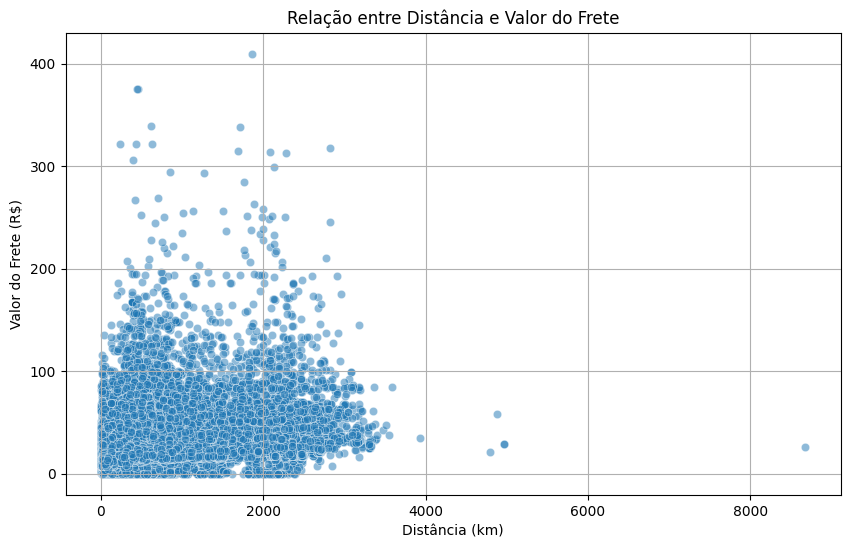

In [ ]:
# Qual a relação entre o valor do frete e a distância de entrega?

df_geo_grouped = df_geolacation.groupby('geolocation_zip_code_prefix')[['geolocation_lat', 'geolocation_lng']].mean().reset_index()
df_geo_grouped.columns = ['zip_code_prefix', 'latitude', 'longitude']

df_sellers_geo = pd.merge(df_sellers, df_geo_grouped, left_on='seller_zip_code_prefix', right_on='zip_code_prefix', how='left')
df_sellers_geo = df_sellers_geo.rename(columns={'latitude': 'seller_latitude', 'longitude': 'seller_longitude'}).drop('zip_code_prefix', axis=1)

df_customers_geo = pd.merge(df_customers, df_geo_grouped, left_on='customer_zip_code_prefix', right_on='zip_code_prefix', how='left')
df_customers_geo = df_customers_geo.rename(columns={'latitude': 'customer_latitude', 'longitude': 'customer_longitude'}).drop('zip_code_prefix', axis=1)

df_orders_full = df_orders.merge(df_orders_items[['order_id', 'seller_id', 'product_shipping_cost']], on='order_id', how='left')
df_orders_full = df_orders_full.merge(df_sellers_geo[['seller_id', 'seller_latitude', 'seller_longitude']], on='seller_id', how='left')
df_orders_full = df_orders_full.merge(df_customers_geo[['customer_id', 'customer_latitude', 'customer_longitude']], on='customer_id', how='left')

def calculate_distance(row):
    try:
        return haversine((row['seller_latitude'], row['seller_longitude']),
                         (row['customer_latitude'], row['customer_longitude']))
    except:
        return None

df_orders_full['distance_km'] = df_orders_full.apply(calculate_distance, axis=1)

df_plot = df_orders_full[['product_shipping_cost', 'distance_km']].dropna()

correlation = df_plot.corr()
print("Correlação entre distância e valor do frete:\n", correlation)

plt.figure(figsize=(10,6))
sns.scatterplot(data=df_plot, x='distance_km', y='product_shipping_cost', alpha=0.5)
plt.title('Relação entre Distância e Valor do Frete')
plt.xlabel('Distância (km)')
plt.ylabel('Valor do Frete (R$)')
plt.grid(True)
plt.show()

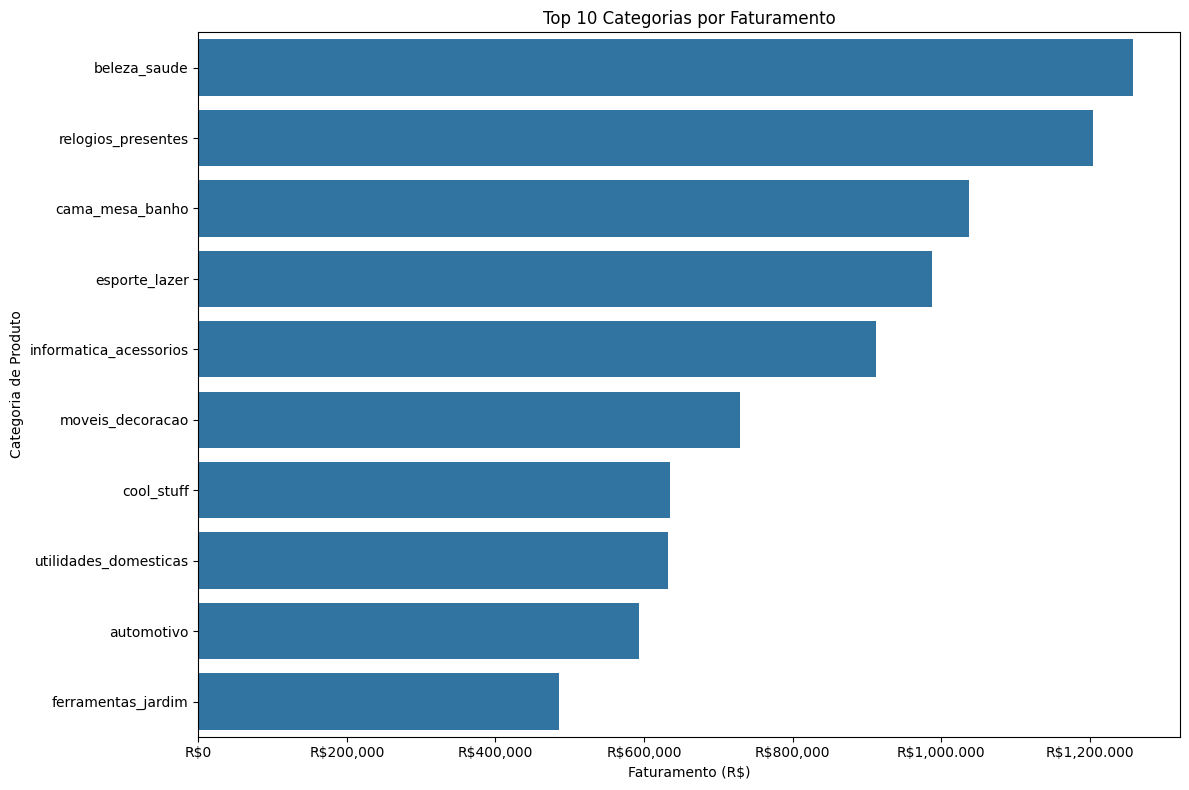

In [ ]:
# Quais são as categorias de produtos mais vendidas em termos de faturamento?

df_orders_items['total_price'] = df_orders_items['product_price'] * df_orders_items['qtd_order_item']
df_merged = pd.merge(df_orders_items, df_products[['product_id', 'product_category_name']], on='product_id', how='left')
category_revenue = df_merged.groupby('product_category_name')['total_price'].sum().reset_index()
category_revenue = category_revenue.sort_values(by='total_price', ascending=False)

plt.figure(figsize=(12,8))
ax = sns.barplot(data=category_revenue.head(10), x='total_price', y='product_category_name')
plt.title('Top 10 Categorias por Faturamento')
plt.xlabel('Faturamento (R$)')
plt.ylabel('Categoria de Produto')
formatter = ticker.FuncFormatter(lambda x, pos: f'R${x:,.0f}'.replace(",", ".").replace(".", ",", 1))
ax.xaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

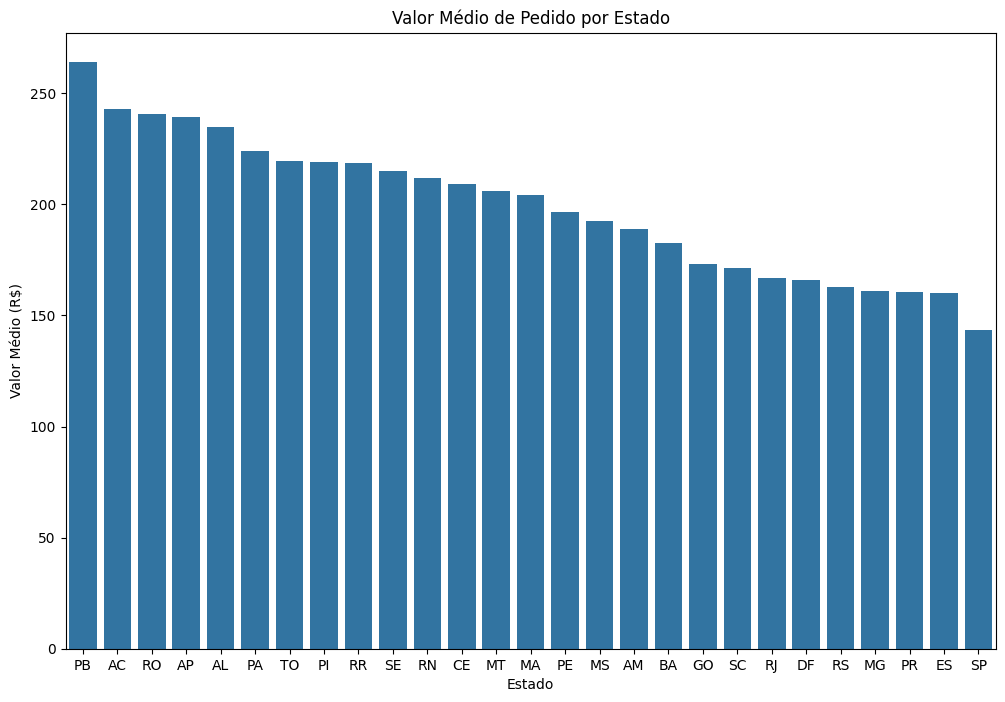

In [ ]:
# Quais estados brasileiros possuem o maior valor médio de pedido?

df_payments = df_payments.groupby('order_id')['total_order_payments'].sum().reset_index()
df_orders_customers = pd.merge(df_orders, df_customers[['customer_id', 'customer_state']], on='customer_id', how='left')
df_orders_customers_payments = pd.merge(df_orders_customers, df_payments, on='order_id', how='left')

state_avg_order_value = df_orders_customers_payments.groupby('customer_state')['total_order_payments'].mean().reset_index()
state_avg_order_value = state_avg_order_value.sort_values(by='total_order_payments', ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(data=state_avg_order_value, x='customer_state' , y='total_order_payments')
plt.title('Valor Médio de Pedido por Estado')
plt.xlabel('Estado')
plt.ylabel('Valor Médio (R$)')
plt.show()